In [2]:
# Import libraries 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from seaborn import displot
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from yellowbrick.classifier import ConfusionMatrix, ClassificationReport
from sklearn.metrics import accuracy_score

# Introduction

Using a dataset that contains data on loans from clients in a bank, I want to build a model that will predict the value of the target variable "bad_flag".

In [3]:
# Load the dataset 
data = pd.read_csv('test_task.csv')

# Data exploration and visualization 

In [4]:
# Display the first few rows
data.head()

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,...,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag
0,708382,2016-10-06,2015-11-13,NaN,NaN,NaN,NaN,3.0,region_6,6,...,10,0,0,0,10.0,NaN,NaN,21.0,False,0
1,406305,2016-03-26,2015-09-28,1.0,0.0,0.0,2016-01-30,0.0,region_6,6,...,6,0,0,0,5.0,NaN,NaN,20.0,False,0
2,779736,2016-10-30,2015-12-21,NaN,NaN,NaN,NaN,2.0,region_1,6,...,0,5,0,0,5.0,NaN,NaN,19.0,False,0
3,556376,2016-06-29,2015-06-30,NaN,NaN,NaN,NaN,1.0,region_6,14,...,4,0,0,0,6.0,NaN,NaN,21.0,False,0
4,266968,2015-12-01,2015-08-03,NaN,NaN,NaN,NaN,0.0,region_5,22,...,0,0,0,0,3.0,NaN,NaN,33.0,False,0


In [5]:
# Check the dimension of the data 
print('Data dimensions:', data.shape)

Data dimensions: (4157, 22)


In [6]:
# Get summary statistics 
print(data.describe())

             loanKey   dpd_5_cnt  dpd_15_cnt  dpd_30_cnt  close_loans_cnt   
count    4157.000000  675.000000  675.000000  675.000000      4142.000000  \
mean   525386.651431    1.444444    0.733333    0.280000         1.184693   
std    202001.338206    0.900599    0.764572    0.502339         1.723715   
min     58567.000000    0.000000    0.000000    0.000000         0.000000   
25%    363964.000000    1.000000    0.000000    0.000000         0.000000   
50%    543603.000000    1.000000    1.000000    0.000000         1.000000   
75%    687271.000000    2.000000    1.000000    1.000000         2.000000   
max    884377.000000    7.000000    5.000000    3.000000        31.000000   

         TraderKey  payment_type_0  payment_type_1  payment_type_2   
count  4157.000000     4157.000000     4157.000000     4157.000000  \
mean     12.338225        0.018523        0.596103        3.755834   
std       9.902927        0.330359        2.564887        3.810703   
min       1.000000        

In [7]:
print(data[['federal_district_nm','gender']].describe())

       federal_district_nm gender
count                 4146   4157
unique                   8      2
top               region_3  False
freq                  1595   3570


In [8]:
# Get more info on the data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4157 entries, 0 to 4156
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loanKey              4157 non-null   int64  
 1   rep_loan_date        4157 non-null   object 
 2   first_loan           4157 non-null   object 
 3   dpd_5_cnt            675 non-null    float64
 4   dpd_15_cnt           675 non-null    float64
 5   dpd_30_cnt           675 non-null    float64
 6   first_overdue_date   675 non-null    object 
 7   close_loans_cnt      4142 non-null   float64
 8   federal_district_nm  4146 non-null   object 
 9   TraderKey            4157 non-null   int64  
 10  payment_type_0       4157 non-null   int64  
 11  payment_type_1       4157 non-null   int64  
 12  payment_type_2       4157 non-null   int64  
 13  payment_type_3       4157 non-null   int64  
 14  payment_type_4       4157 non-null   int64  
 15  payment_type_5       4157 non-null   i

In [9]:
# Check for missing values 
print('Missing values: \n', data.isnull().sum())

Missing values: 
 loanKey                   0
rep_loan_date             0
first_loan                0
dpd_5_cnt              3482
dpd_15_cnt             3482
dpd_30_cnt             3482
first_overdue_date     3482
close_loans_cnt          15
federal_district_nm      11
TraderKey                 0
payment_type_0            0
payment_type_1            0
payment_type_2            0
payment_type_3            0
payment_type_4            0
payment_type_5            0
past_billings_cnt       248
score_1                 650
score_2                3918
age                       0
gender                    0
bad_flag                  0
dtype: int64


In [10]:
data['bad_flag'].value_counts()

bad_flag
0    3740
1     417
Name: count, dtype: int64

## Data visualization

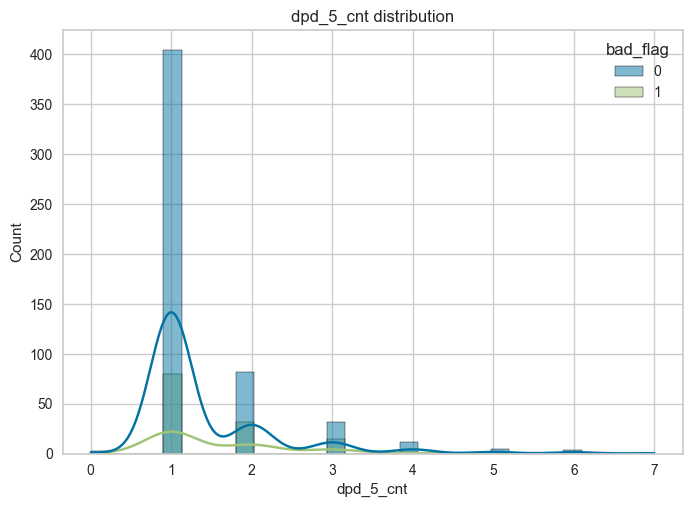

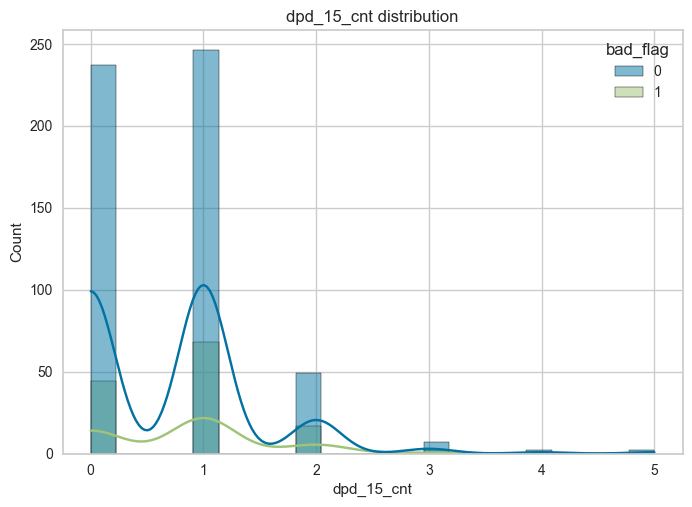

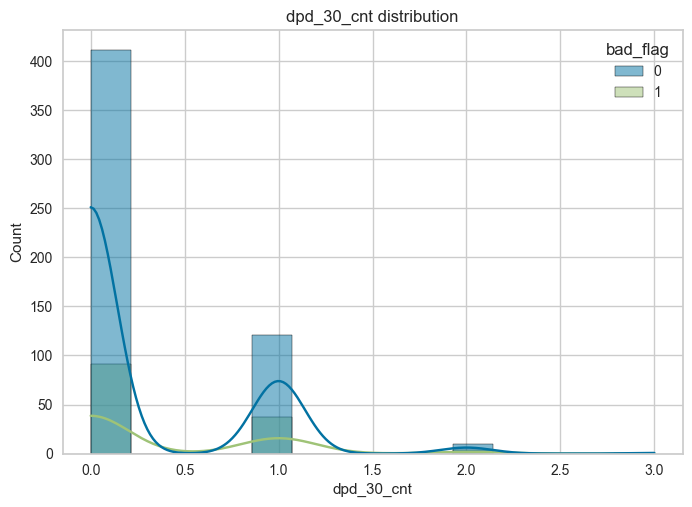

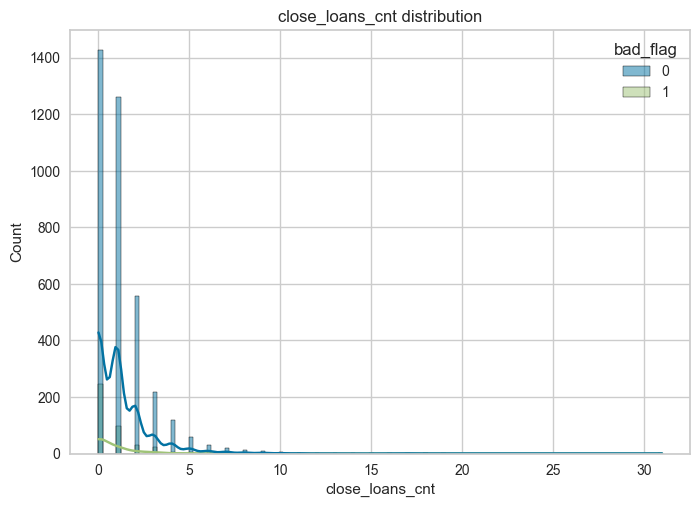

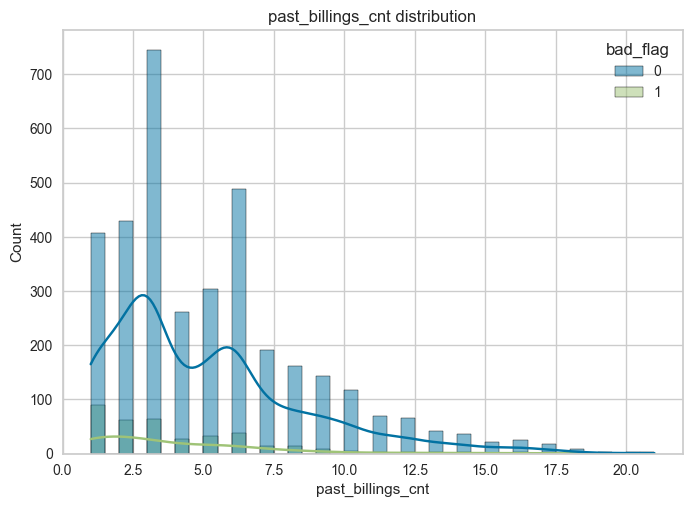

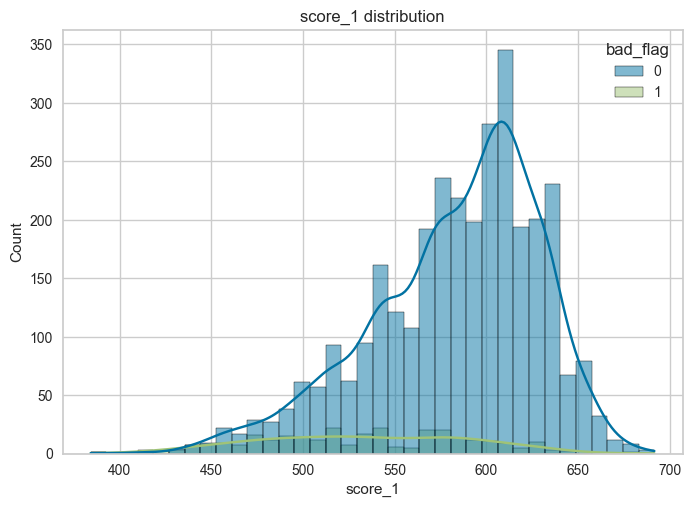

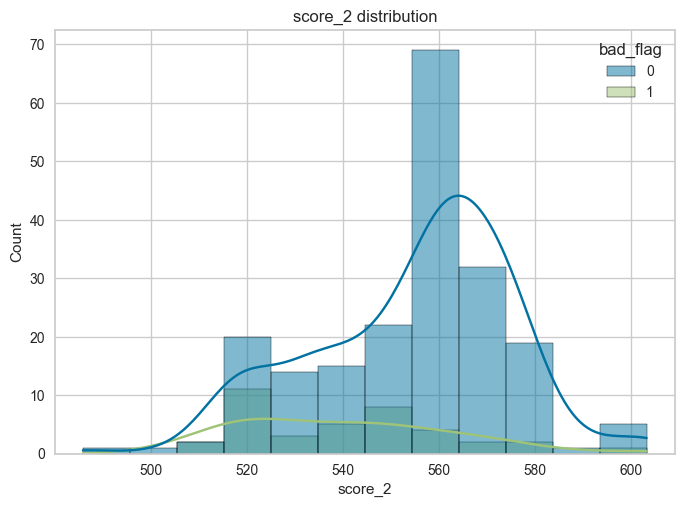

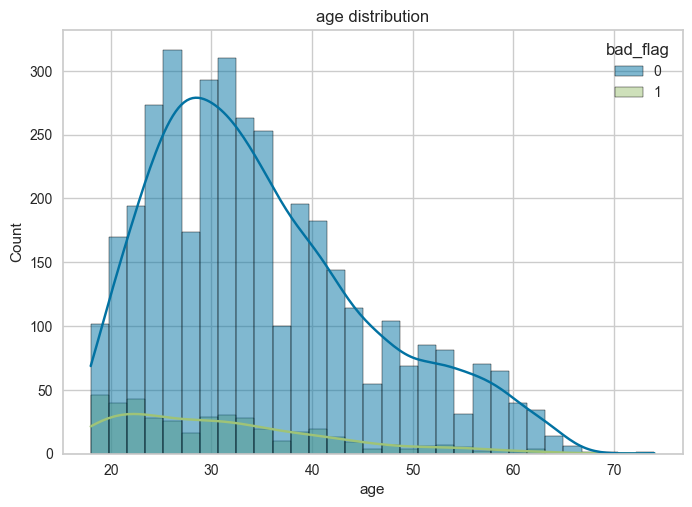

In [11]:
# Histograms for numerical features
num_features = ['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'close_loans_cnt', 'past_billings_cnt', 'score_1', 'score_2', 'age']
for feature in num_features:
    plt.figure()
    sns.histplot(data=data, x=feature, hue='bad_flag', kde=True)
    plt.title(f'{feature} distribution')

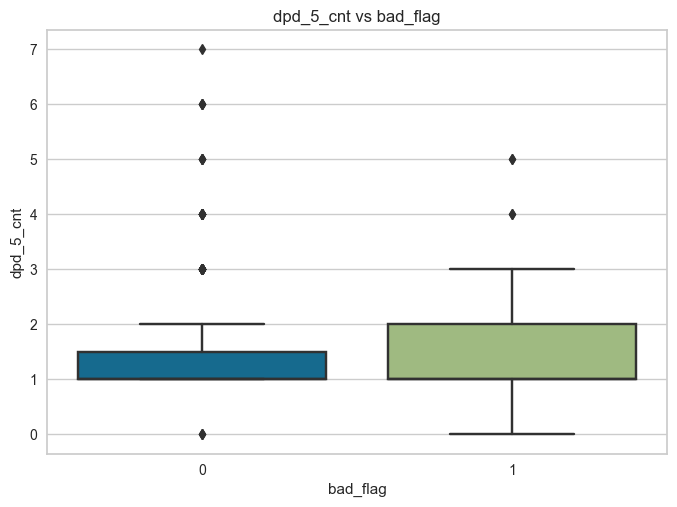

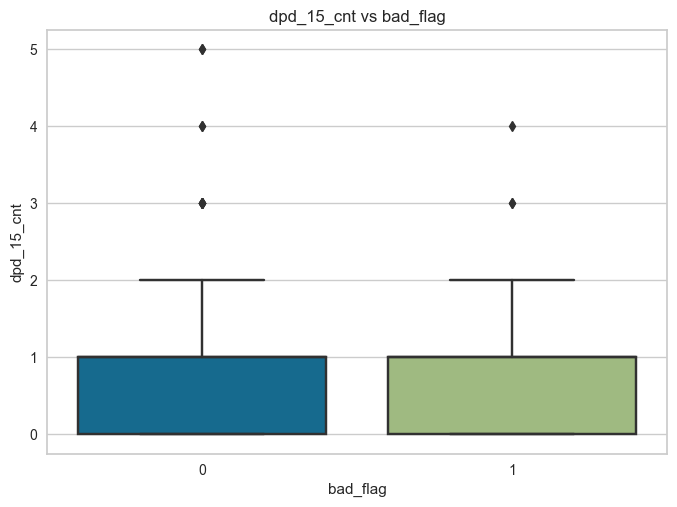

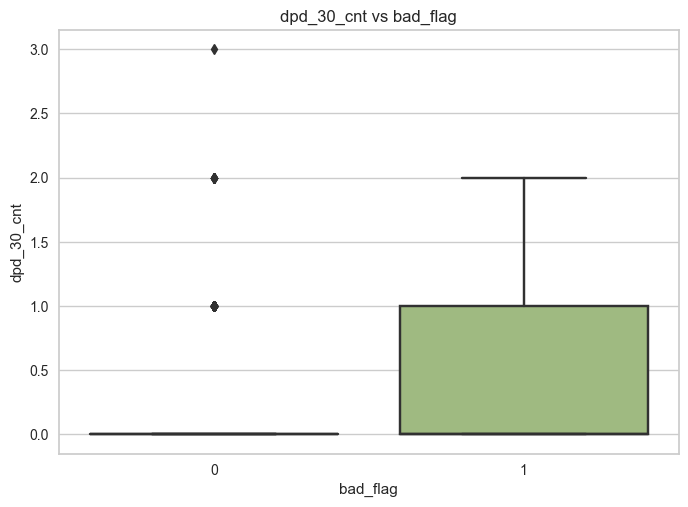

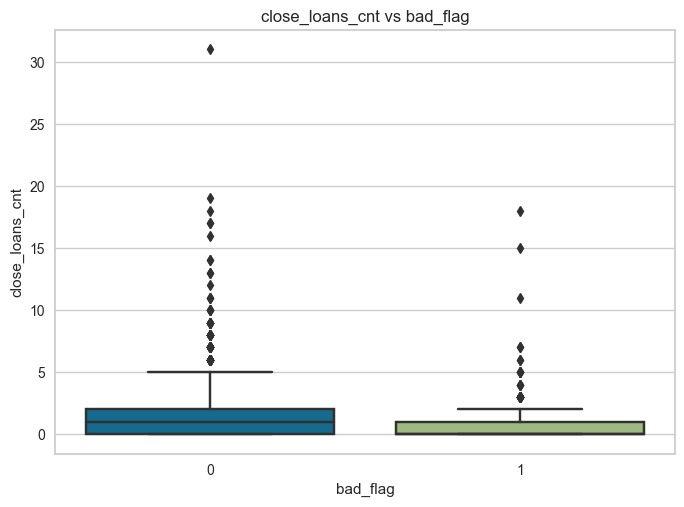

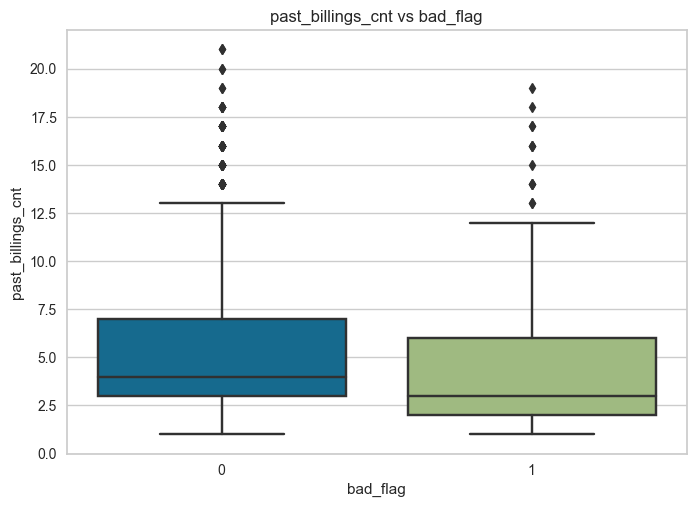

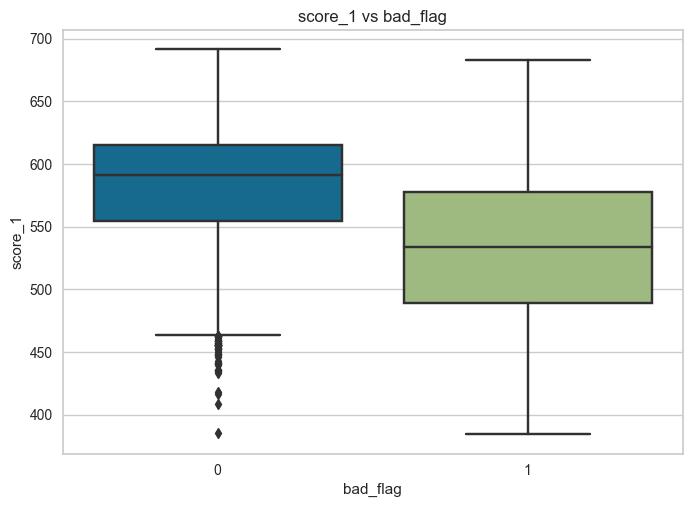

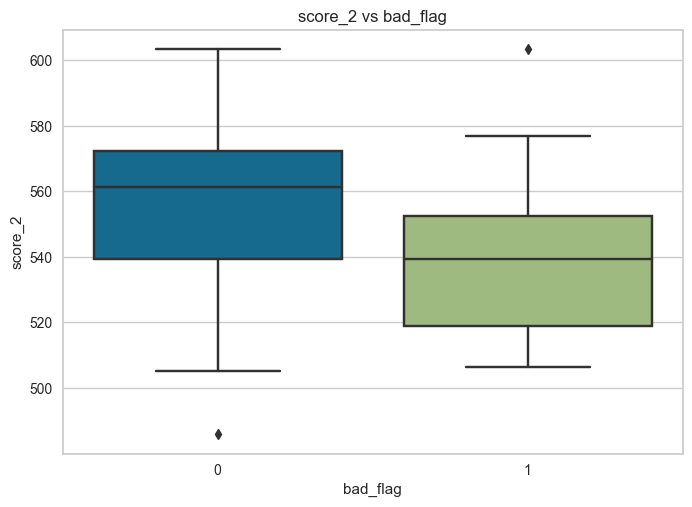

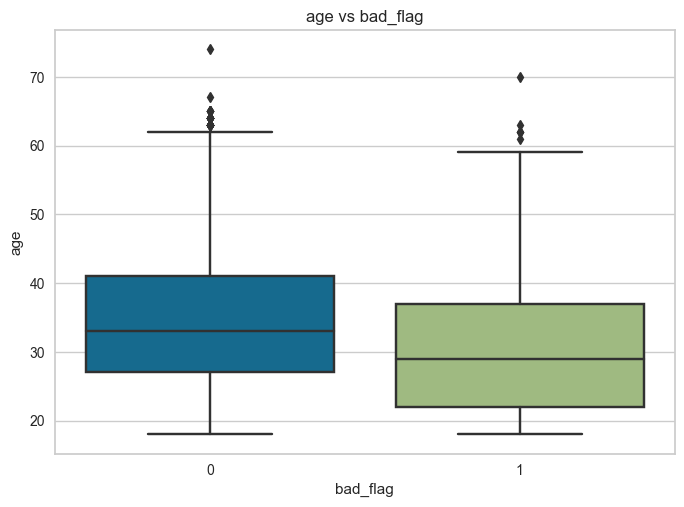

In [12]:
# Box plots for numerical features
for feature in num_features:
    plt.figure()
    sns.boxplot(x='bad_flag', y=feature, data=data)
    plt.title(f'{feature} vs bad_flag')

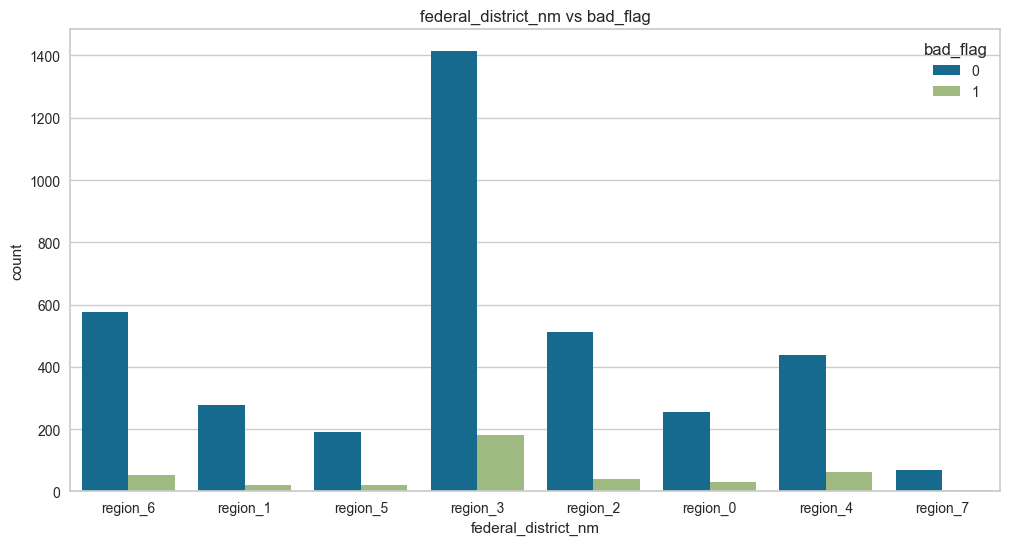

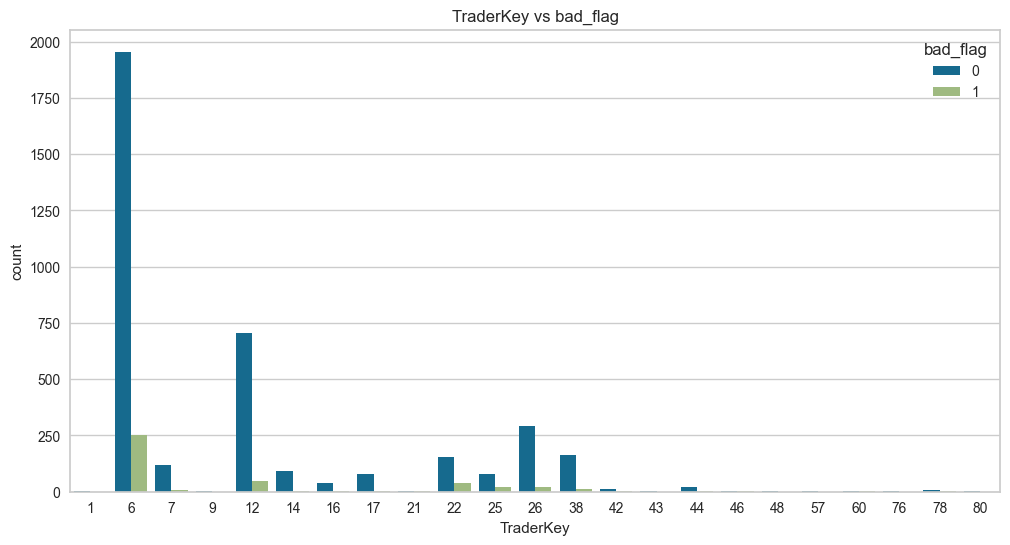

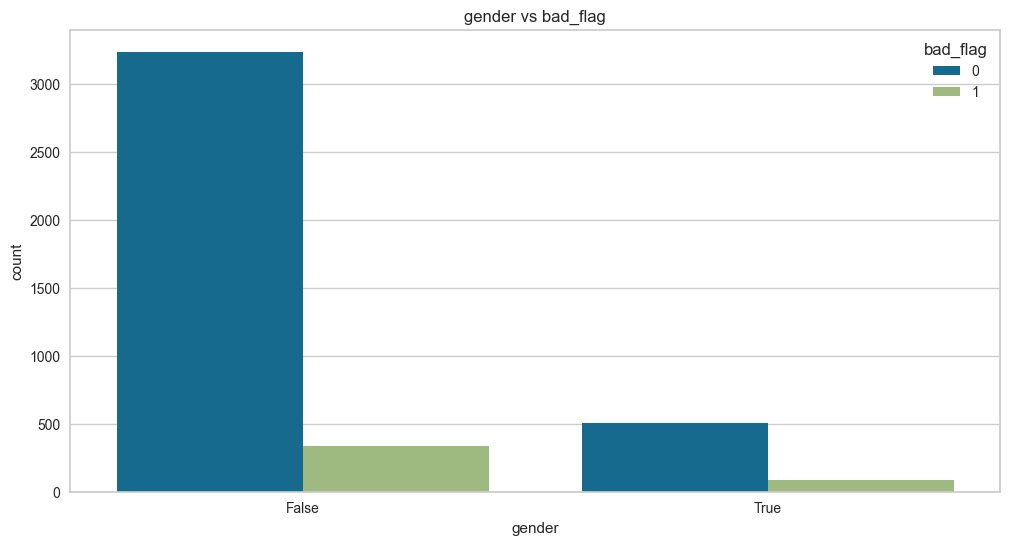

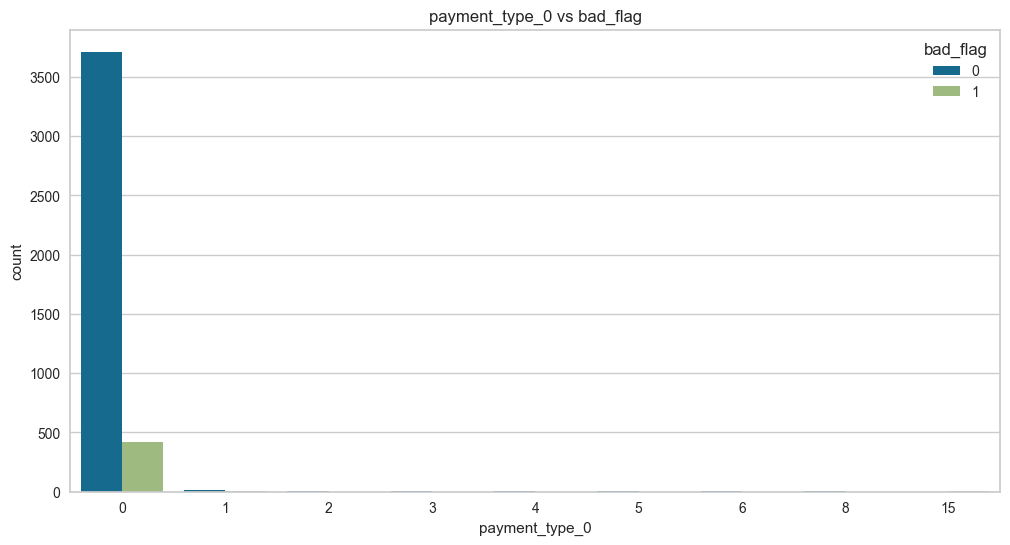

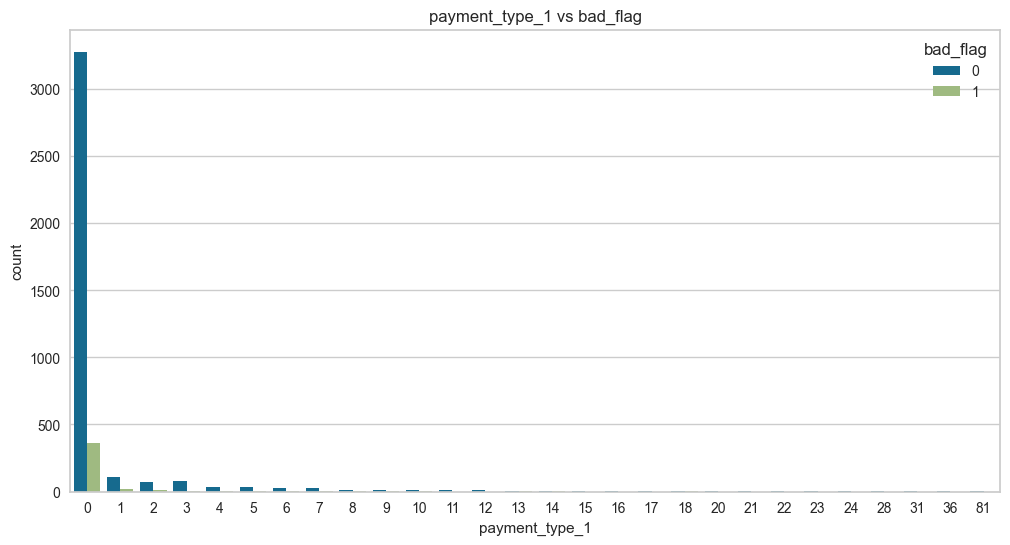

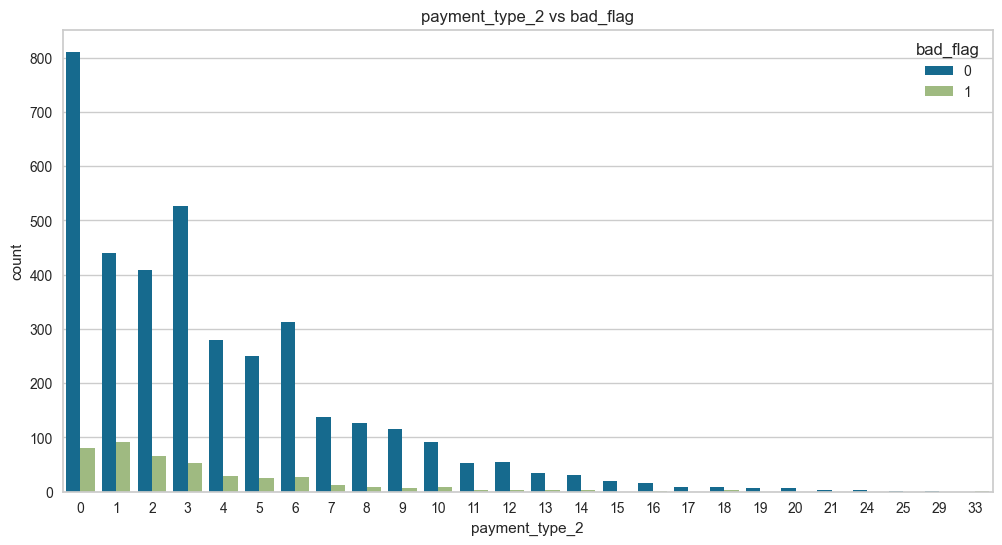

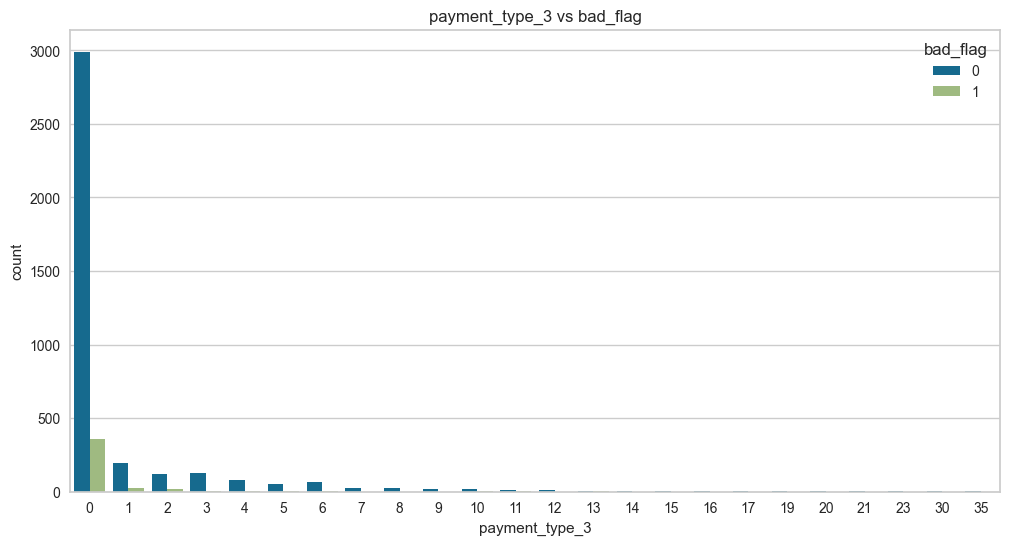

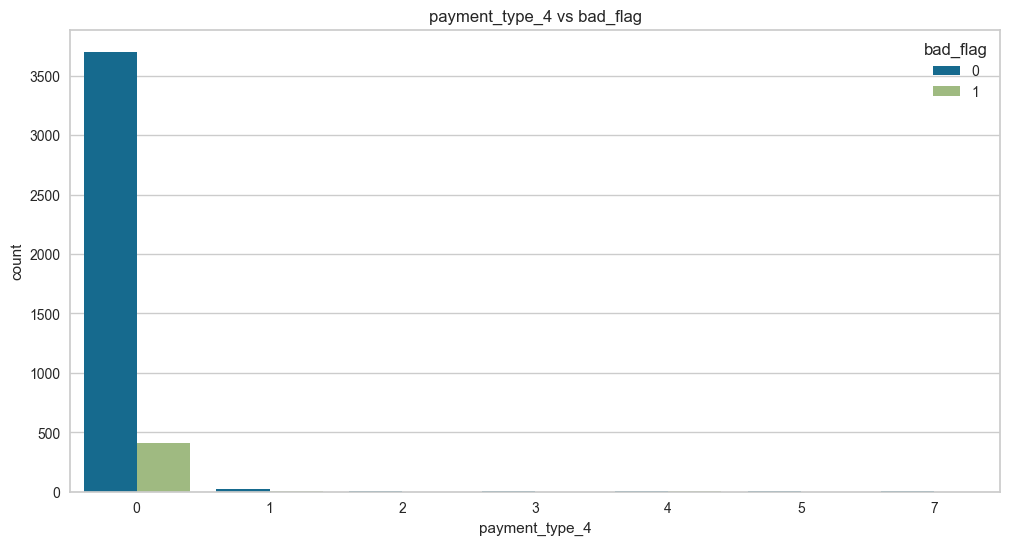

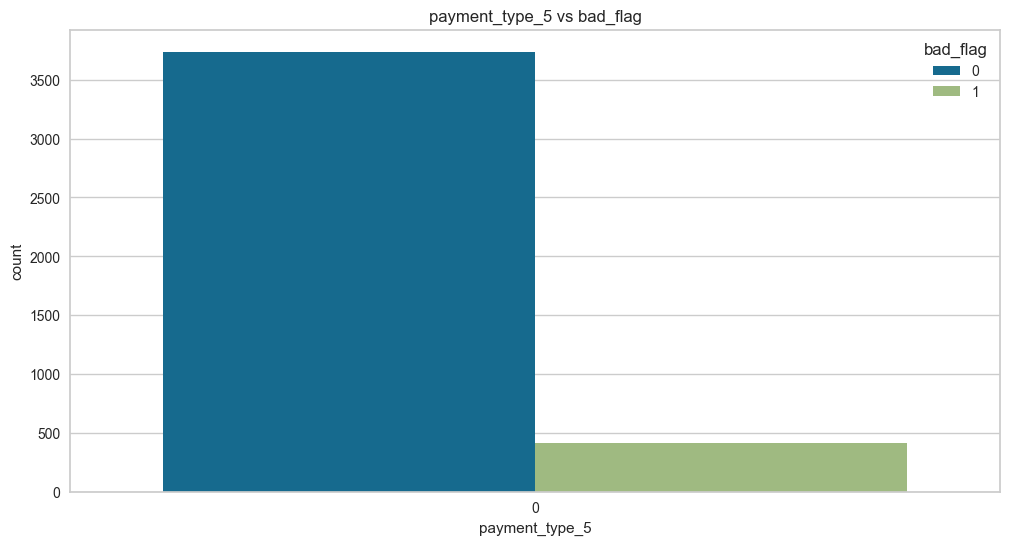

In [13]:
# Bar plots for categorical features
cat_features = ['federal_district_nm', 'TraderKey', 'gender', 'payment_type_0', 'payment_type_1', 'payment_type_2', 'payment_type_3', 'payment_type_4', 'payment_type_5']
for feature in cat_features:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=feature, hue='bad_flag', data=data)
    plt.title(f'{feature} vs bad_flag')

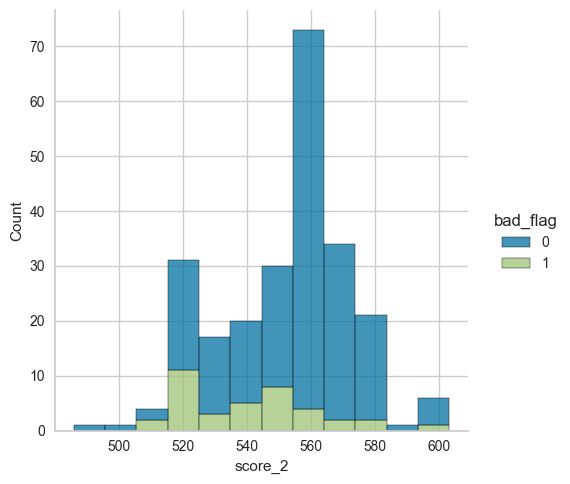

In [14]:
# Plot the distribution of score_2 conditionned by the 'bad_flag' variable
_ = displot(data=data, x="score_2", hue="bad_flag", multiple="stack")


<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


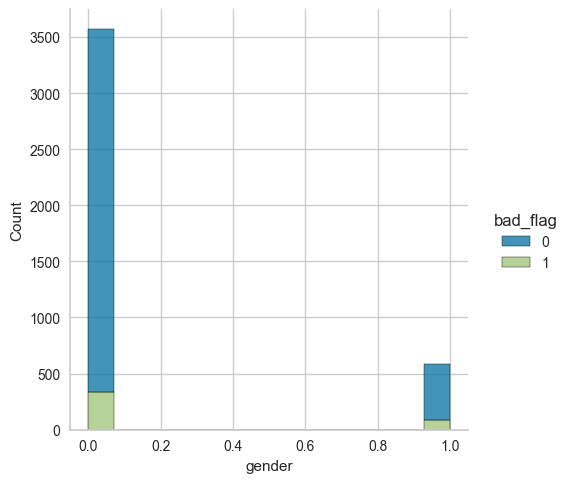

In [15]:
_ = displot(data=data, x="gender", hue="bad_flag", multiple="stack")

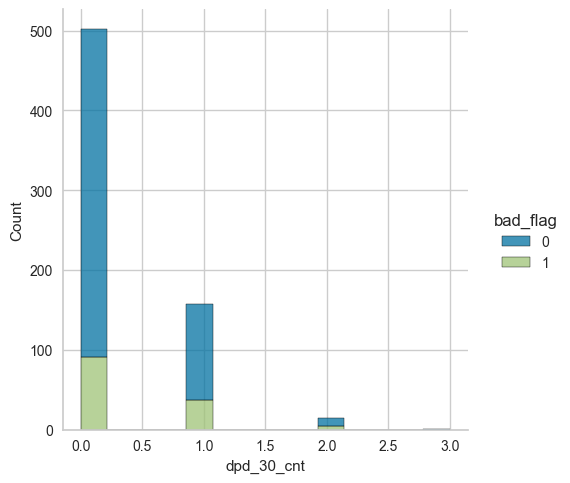

In [16]:
_ = displot(data=data, x="dpd_30_cnt", hue="bad_flag", multiple="stack")

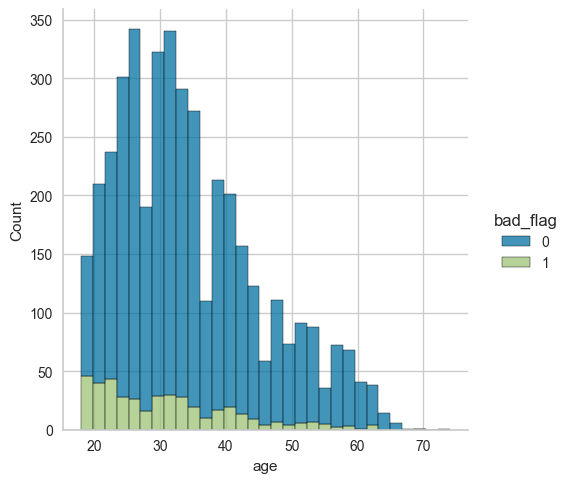

In [17]:
_ = displot(data=data, x="age", hue="bad_flag", multiple="stack")

# Data preprocessing 

In [18]:
# Fill missing values for numerical features with their median value when the proportion of missing data is not too high
num_features_with_missing = ['close_loans_cnt', 'past_billings_cnt', 'score_1']
for feature in num_features_with_missing:
    data[feature] = data[feature].fillna(data[feature].median())

# Fill missing values for categorical features with their mode
cat_features_with_missing = ['federal_district_nm']
for feature in cat_features_with_missing:
    data[feature] = data[feature].fillna(data[feature].mode()[0])

In [19]:
# Using KNN Imputer for the features that have a percentage of missing data too large 
imputer = KNNImputer(n_neighbors=5)

# Select the features that need imputation
features_to_impute = ['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'score_2']
data[features_to_impute] = imputer.fit_transform(data[features_to_impute])

In [20]:
# Create a new feature representing the days between the 'first_overdue_date' and 'first_loan' 
data['first_overdue_date'] = pd.to_datetime(data['first_overdue_date'])
data['first_loan'] = pd.to_datetime(data['first_loan'])

data['days_to_first_overdue'] = (data['first_overdue_date'] - data['first_loan']).dt.days

# Imputing the missing values from 'days_to_first_overdue'
imputer = KNNImputer(n_neighbors=5)

# Select the feature that needs imputation
feature_to_impute = ['days_to_first_overdue']
data[feature_to_impute] = imputer.fit_transform(data[feature_to_impute])

# Droping 'first_overdue_date'
data = data.drop('first_overdue_date', axis=1)
data = data.drop('rep_loan_date', axis=1)
data = data.drop('first_loan', axis=1)
data = data.drop('loanKey', axis=1)

In [21]:
print('Missing values: \n', data.isnull().sum())

Missing values: 
 dpd_5_cnt                0
dpd_15_cnt               0
dpd_30_cnt               0
close_loans_cnt          0
federal_district_nm      0
TraderKey                0
payment_type_0           0
payment_type_1           0
payment_type_2           0
payment_type_3           0
payment_type_4           0
payment_type_5           0
past_billings_cnt        0
score_1                  0
score_2                  0
age                      0
gender                   0
bad_flag                 0
days_to_first_overdue    0
dtype: int64


In [22]:
# One-hot encoding for categorical variables
data = pd.get_dummies(data, columns=['federal_district_nm', 'gender'], drop_first=True)

# Feature Selection

## Correlation analaysis

In [23]:
correlations = data.corr()['bad_flag'].abs().sort_values(ascending=False)
print(correlations)

bad_flag                        1.000000
score_1                         0.228731
age                             0.106962
past_billings_cnt               0.087996
close_loans_cnt                 0.071090
payment_type_3                  0.065221
payment_type_2                  0.061194
score_2                         0.059010
gender_True                     0.055454
days_to_first_overdue           0.041270
dpd_15_cnt                      0.038581
federal_district_nm_region_3    0.037657
federal_district_nm_region_2    0.034125
dpd_30_cnt                      0.033109
federal_district_nm_region_4    0.029427
dpd_5_cnt                       0.029109
federal_district_nm_region_1    0.025046
federal_district_nm_region_6    0.024380
payment_type_0                  0.020062
federal_district_nm_region_7    0.014674
TraderKey                       0.012134
payment_type_1                  0.011732
payment_type_4                  0.006104
federal_district_nm_region_5    0.001331
payment_type_5  

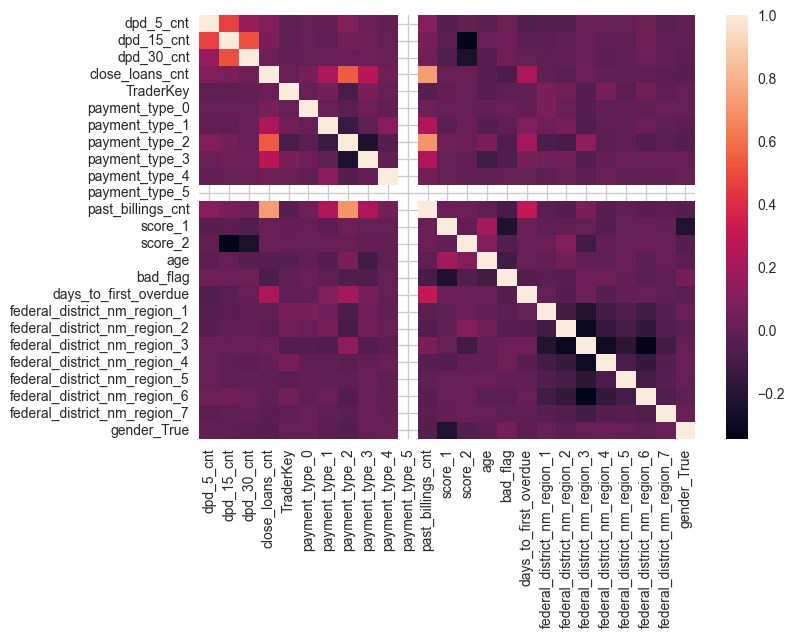

In [24]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix)
plt.show()

# Feature importances

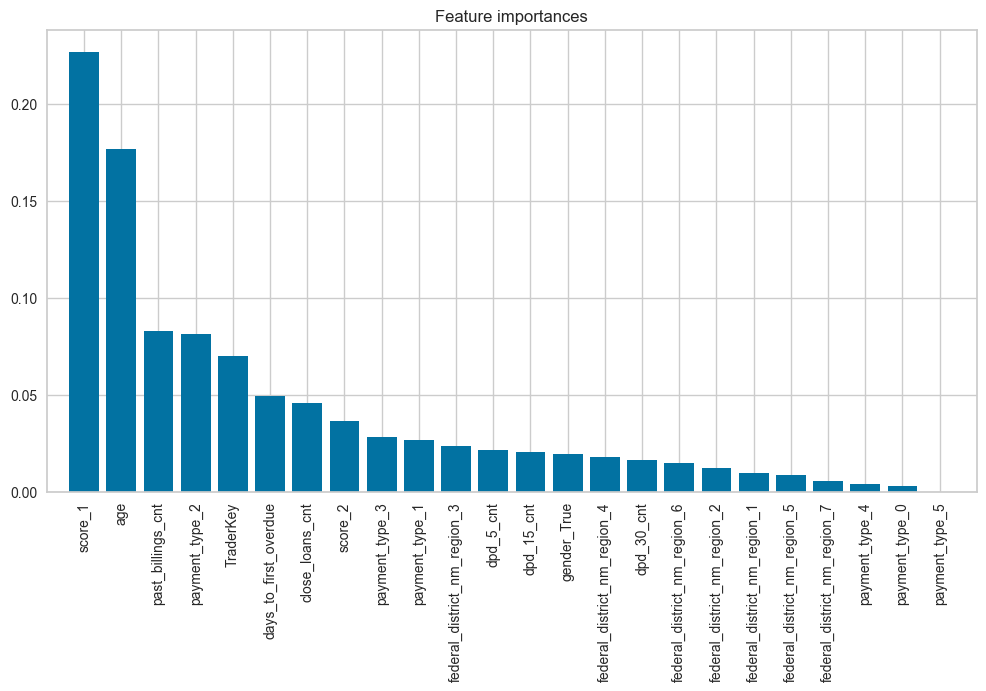

In [25]:
from sklearn.ensemble import RandomForestClassifier

X = data.drop('bad_flag', axis=1)
y = data['bad_flag']

model = RandomForestClassifier()
model.fit(X, y)

# Plot feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## Feature engineering

In [26]:
# Create a new feature 'loan_billing_ratio' 
data['loan_billing_ratio'] = data['close_loans_cnt'] / data['past_billings_cnt']

# Drop the original features 'close_loans_cnt' and 'past_billings_cnt'
data = data.drop(['close_loans_cnt', 'past_billings_cnt'], axis=1)

# Model training and selection

In [36]:
def evaluate_model(model, X, y, cv=5):
    pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('model', model)])
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv)
    return scores.mean()

# Prepare the dataset
X = data.drop(['bad_flag'], axis=1)
y = data['bad_flag']

# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier( eval_metric='logloss')
}

# Train and evaluate each model using cross-validation
results = {}
for name, model in models.items():
    auc = evaluate_model(model, X, y)
    results[name] = auc
    print(f'{name}: AUC = {auc:.4f}')

Logistic Regression: AUC = 0.7260
Random Forest: AUC = 0.7632
XGBoost: AUC = 0.7539


In [28]:
# Parameter grids for each model
param_grid_lr = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}

param_grid_xgb = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 6, 9]
}

In [29]:
def optimize_parameters(model, param_grid, X, y, cv=5):
    pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('model', model)])
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', cv=cv)
    grid_search.fit(X, y)
    return grid_search.best_params_

In [30]:
# Logistic Regression
best_params_lr = optimize_parameters(models['Logistic Regression'], param_grid_lr, X, y)
print(f'Best parameters for Logistic Regression: {best_params_lr}')

# Random Forest
best_params_rf = optimize_parameters(models['Random Forest'], param_grid_rf, X, y)
print(f'Best parameters for Random Forest: {best_params_rf}')

# XGBoost
best_params_xgb = optimize_parameters(models['XGBoost'], param_grid_xgb, X, y)
print(f'Best parameters for XGBoost: {best_params_xgb}')

Best parameters for Logistic Regression: {'model__C': 0.01}
Best parameters for Random Forest: {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 200}


c:\Users\Stephanie\Documents\GitHub\Flag_Loans\env\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Stephanie\Documents\GitHub\Flag_Loans\env\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Stephanie\Documents\GitHub\Flag_Loans\env\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Stephanie\Documents\GitHub\Flag_Loans\env\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Stephanie\Documents\GitHub\Flag_Loans\env\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 

Best parameters for XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}


c:\Users\Stephanie\Documents\GitHub\Flag_Loans\env\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [37]:
# Initialize the models with the good parameters
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=0.01),
    'Random Forest': RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=300),
    'XGBoost': XGBClassifier(learning_rate= 0.1, eval_metric='logloss', max_depth= 3, n_estimators=100)
}

# Train and evaluate each model using cross-validation
results = {}
for name, model in models.items():
    auc = evaluate_model(model, X, y)
    results[name] = auc
    print(f'{name}: AUC = {auc:.4f}')

Logistic Regression: AUC = 0.7275
Random Forest: AUC = 0.7924
XGBoost: AUC = 0.7904


Logistic Regression Accuracy: 0.90


c:\Users\Stephanie\Documents\GitHub\Flag_Loans\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


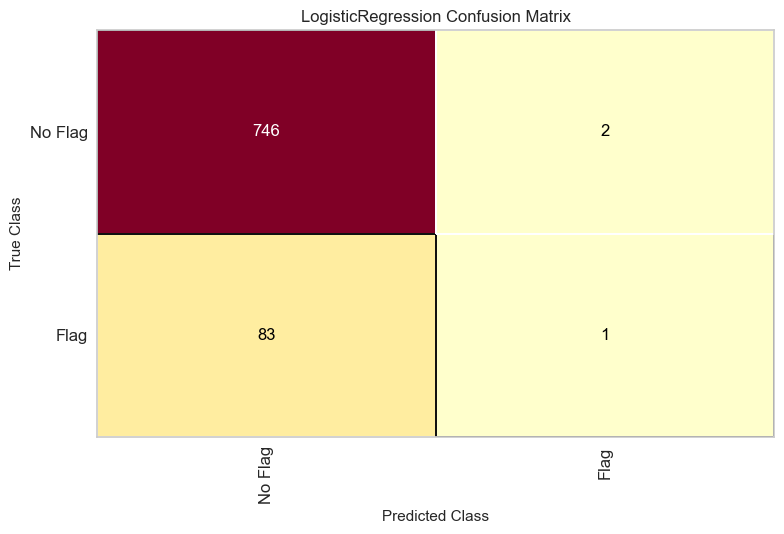

c:\Users\Stephanie\Documents\GitHub\Flag_Loans\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


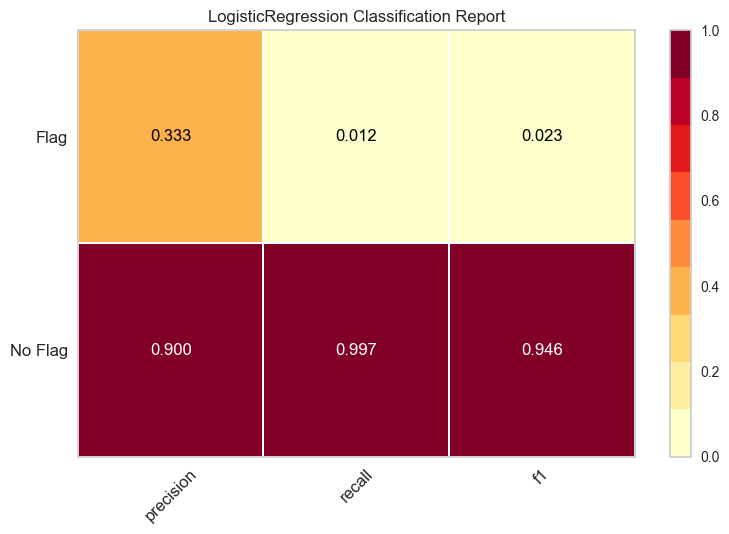

Random Forest Accuracy: 0.89


c:\Users\Stephanie\Documents\GitHub\Flag_Loans\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


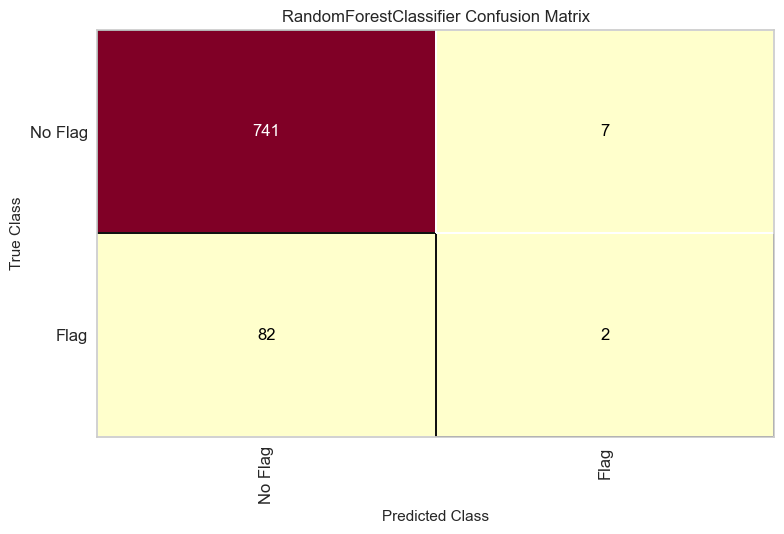

c:\Users\Stephanie\Documents\GitHub\Flag_Loans\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


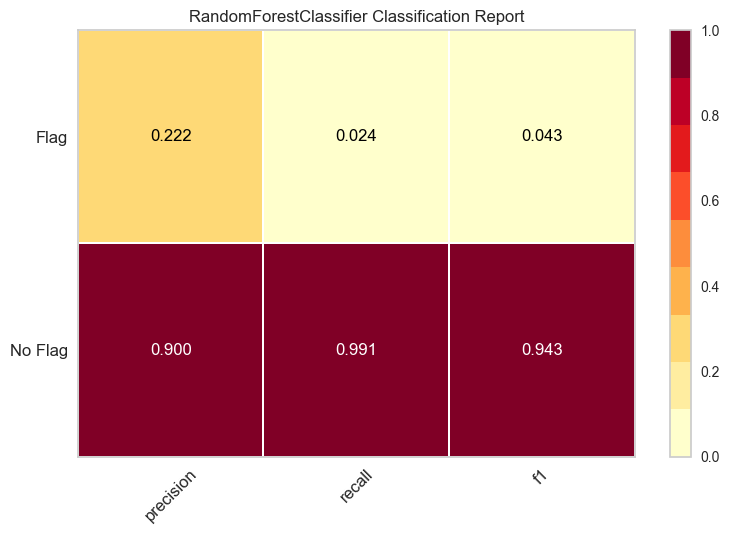

XGBoost Accuracy: 0.89


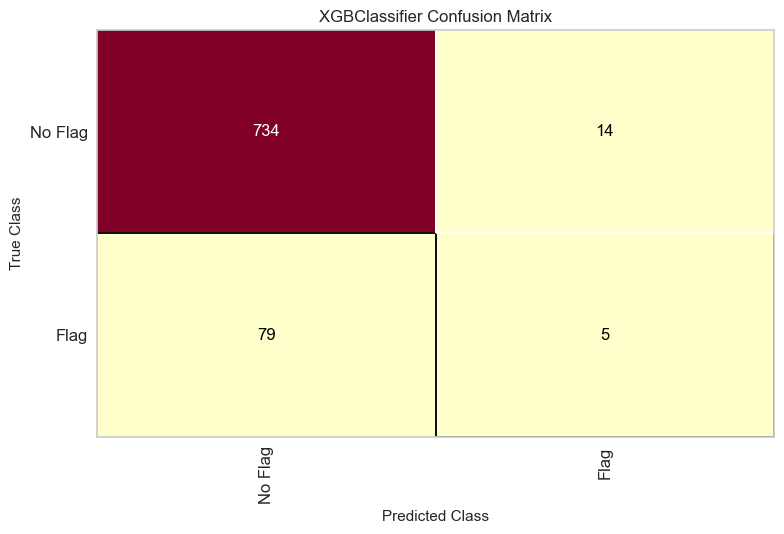

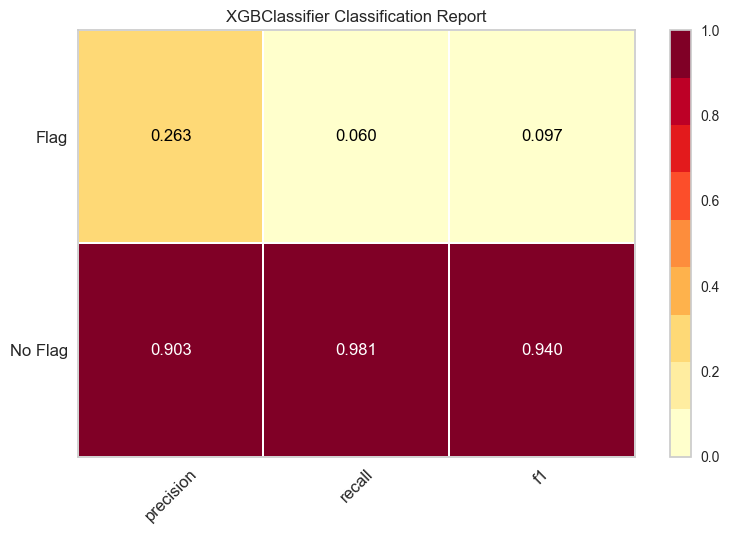

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Assuming you already have X and y defined

for name, model in models.items():
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict the test data
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{name} Accuracy: {accuracy:.2f}")
    
    # Visualize the confusion matrix
    cm = ConfusionMatrix(model, classes=["No Flag", "Flag"])
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)
    cm.show()
    
    # Visualize the classification report
    cr = ClassificationReport(model, classes=["No Flag", "Flag"])
    cr.fit(X_train, y_train)
    cr.score(X_test, y_test)
    cr.show()

XGBoost has better performance but we can see that it does struggle with imbalanced classes (the number of good customers is significantly larger than the number of bad customers). 

# Rebalancing our data set

## Resampling

In [33]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

Logistic Regression Accuracy: 0.78


c:\Users\Stephanie\Documents\GitHub\Flag_Loans\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


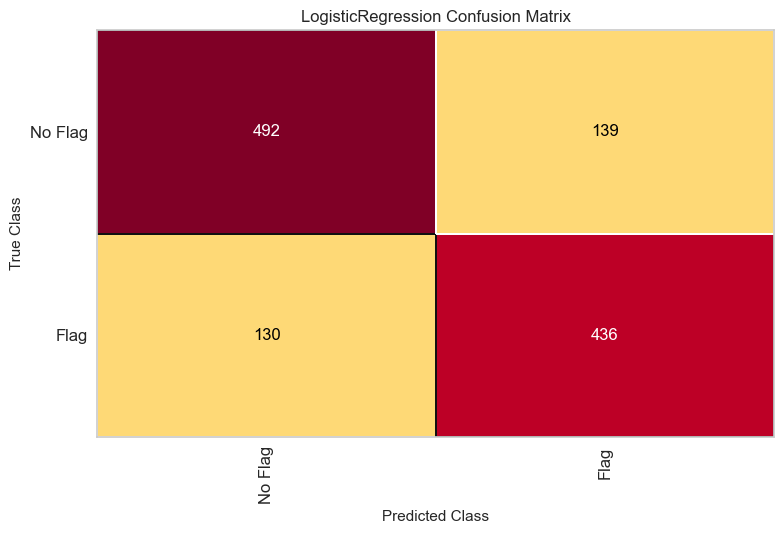

c:\Users\Stephanie\Documents\GitHub\Flag_Loans\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


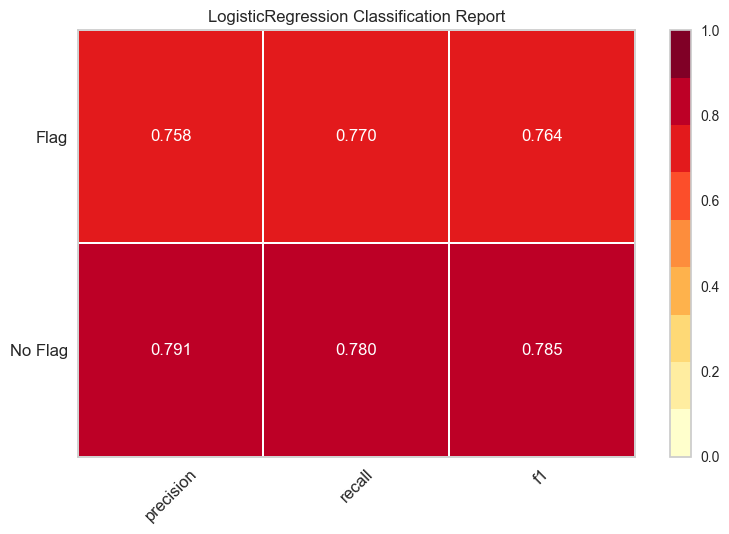

Random Forest Accuracy: 0.89


c:\Users\Stephanie\Documents\GitHub\Flag_Loans\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


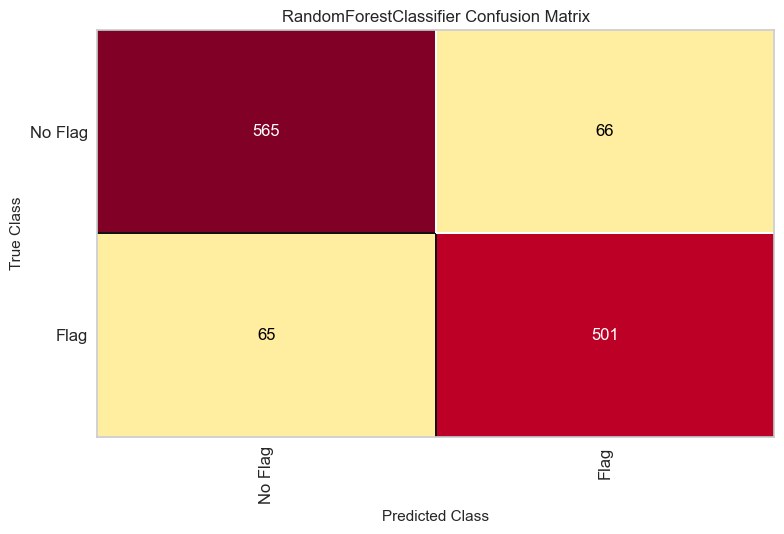

c:\Users\Stephanie\Documents\GitHub\Flag_Loans\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


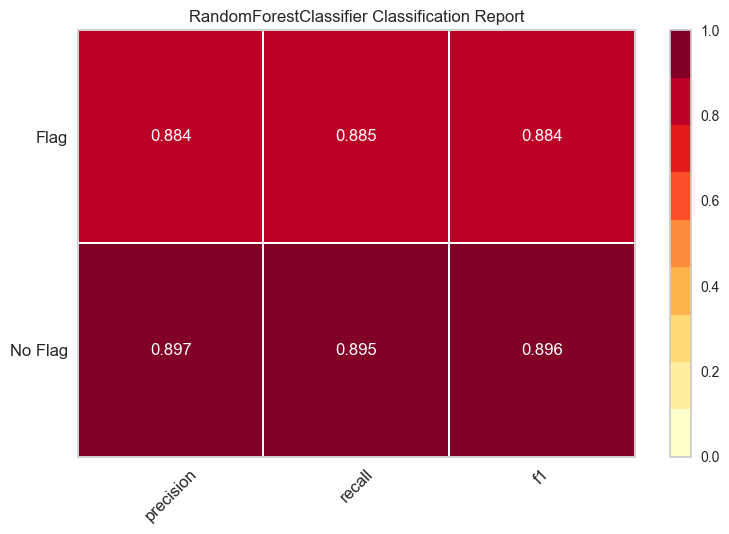

XGBoost Accuracy: 0.89


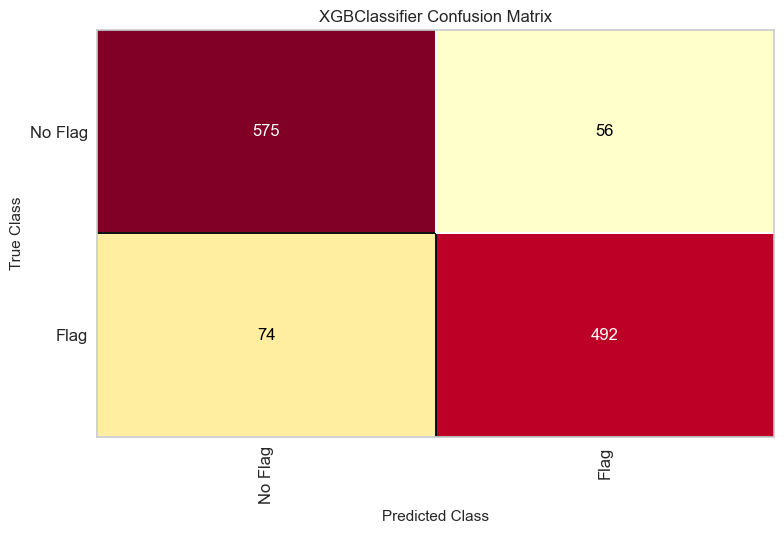

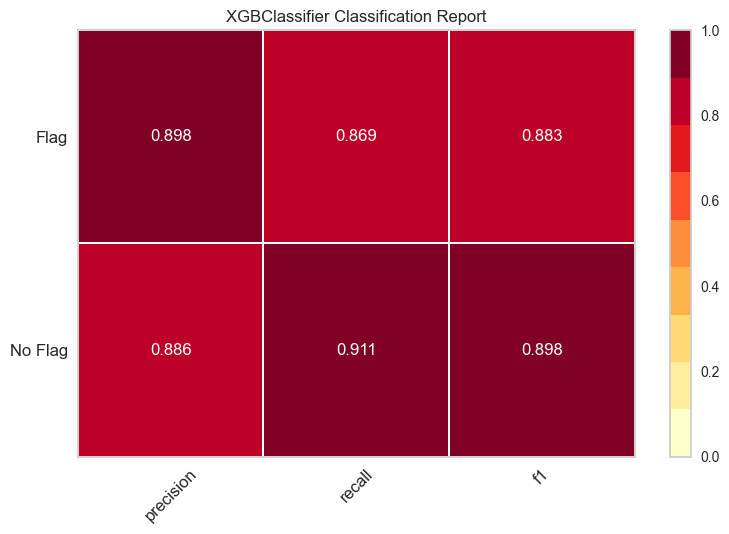

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)  # Assuming you already have X and y defined

for name, model in models.items():
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict the test data
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{name} Accuracy: {accuracy:.2f}")
    
    # Visualize the confusion matrix
    cm = ConfusionMatrix(model, classes=["No Flag", "Flag"])
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)
    cm.show()
    
    # Visualize the classification report
    cr = ClassificationReport(model, classes=["No Flag", "Flag"])
    cr.fit(X_train, y_train)
    cr.score(X_test, y_test)
    cr.show()